In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py

In [2]:
class Data(object):
    def __init__(self, fname):
        self.f = h5py.File(fname, "r")
        
    @property
    def sequences(self):
        return self.f["sequences"].value
    
    @property
    def phi2(self):
        return self.f["phi-2"].value

    @property
    def phi3(self):
        return self.f["phi-3"].value

    @property
    def rsquared2(self):
        return self.f["rsquared-2"].value

    @property
    def rsquared3(self):
        return self.f["rsquared-3"].value

In [3]:
d = Data("scripts/test.hdf5")

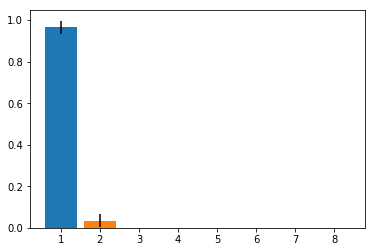

In [23]:
m = np.mean(d.phi2, axis=0)
s = np.std(d.phi2, axis=0)
for i in range(0,8):
    plt.bar(i+1, m[i], yerr=s[i], color="C"+str(i))

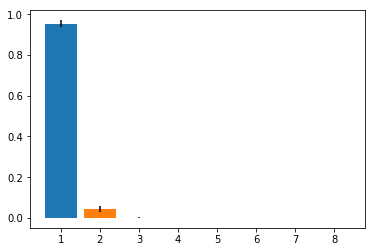

In [24]:
m = np.mean(d.phi3, axis=0)
s = np.std(d.phi3, axis=0)
for i in range(0,8):
    plt.bar(i+1, m[i], yerr=s[i], color="C"+str(i))

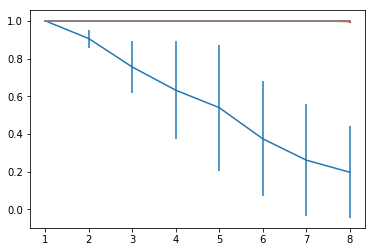

In [25]:
for i in range(8):
    m = np.mean(d.rsquared2[:, i, :], axis=0)
    s = np.std(d.rsquared2[:, i, :], axis=0)
    plt.errorbar(range(1,9), m, yerr=s)

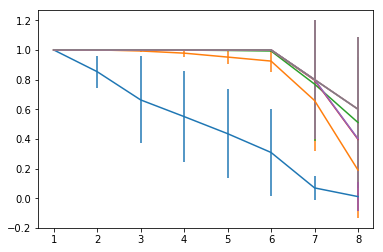

In [26]:
for i in range(8):
    m = np.mean(d.rsquared3[:, i, :], axis=0)
    s = np.std(d.rsquared3[:, i, :], axis=0)
    plt.errorbar(range(1,9), m, yerr=s)

# FOR TESTING

In [8]:
import numpy as np
import h5py
import networkx as nx

from epistasis.models.linear import EpistasisLinearRegression
from epistasis.simulate import LinearSimulation, NonlinearSimulation
from epistasis.stats import pearson
from epistasis.plot import coefs

from latticeproteins.sequences import RandomSequence

from latticegpm import LatticeGenotypePhenotypeMap
from latticegpm.thermo import LatticeThermodynamics
from latticegpm.search import adaptive_walk, get_lowest_confs

In [9]:
i = 0
wildtype = d.sequences[i][0].astype(str)
mutant = d.sequences[i][1].astype(str)

In [10]:
cs = get_lowest_confs(wildtype, 3, database="scripts/database")
wt = LatticeThermodynamics(wildtype, conf_list=cs, temperature=1)
mut = LatticeThermodynamics(mutant, conf_list=cs, temperature=1)

In [11]:
gpm = LatticeGenotypePhenotypeMap.from_Lattice(wt, mut, temperature=1, target_conf=wt.conf_list[0])
gpm.phenotype_type = "stabilities"
gmodel2 = EpistasisLinearRegression.from_gpm(gpm, order=8, model_type="global")
gmodel2.fit()

/Users/Zsailer/.virtualenvs/py3/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)
